# Clasificación de Imágenes con Random Forest
Este notebook clasifica imágenes en 4 categorías: benign, early, pre, y pro

In [13]:
# Importar librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm
import pickle

In [2]:
# Configuración
DATASET_PATH = 'dataset'
IMG_SIZE = (512, 512)  # Redimensionar imágenes para reducir dimensionalidad
CLASSES = ['kidney_normal', 'kidney_tumor']
RANDOM_STATE = 42

In [3]:
# Función para cargar y preprocesar imágenes
def load_images(dataset_path, classes, img_size):
    X = []
    y = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        print(f"Cargando clase: {class_name}")
        
        images = os.listdir(class_path)
        
        for img_name in tqdm(images):
            try:
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img, dtype=np.float32) / 255.0  # Escalar directamente
                img_array = img_array.flatten()  # Convertir a vector 1D
                X.append(img_array)
                y.append(class_idx)
            except Exception as e:
                print(f"Error cargando {img_path}: {e}")
    
    return np.array(X, dtype=np.float32), np.array(y)

In [4]:
# Cargar todas las imágenes
print("Iniciando carga de imágenes...")
X, y = load_images(DATASET_PATH, CLASSES, IMG_SIZE)
print(f"Total de imágenes cargadas: {len(X)}")
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

Iniciando carga de imágenes...
Cargando clase: kidney_normal


  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [00:14<00:00, 408.39it/s]


Cargando clase: kidney_tumor


100%|██████████| 6000/6000 [00:21<00:00, 278.88it/s]


Total de imágenes cargadas: 12000
Forma de X: (12000, 786432)
Forma de y: (12000,)


In [5]:
# Dividir datos: 70% entrenamiento, 15% validación, 15% prueba
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_STATE
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} imágenes ({100*len(X_train)/len(X):.1f}%)")
print(f"Conjunto de validación: {X_val.shape[0]} imágenes ({100*len(X_val)/len(X):.1f}%)")
print(f"Conjunto de prueba: {X_test.shape[0]} imágenes ({100*len(X_test)/len(X):.1f}%)")

Conjunto de entrenamiento: 8404 imágenes (70.0%)
Conjunto de validación: 1796 imágenes (15.0%)
Conjunto de prueba: 1800 imágenes (15.0%)


In [6]:
# Entrenar el modelo Random Forest
print("Entrenando modelo Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)
print("Modelo entrenado exitosamente")

Entrenando modelo Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.0min


Modelo entrenado exitosamente


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


In [7]:
# Evaluar en conjunto de validación
print("\n=== RESULTADOS EN VALIDACIÓN ===")
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {val_accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_val, y_val_pred, target_names=CLASSES))


=== RESULTADOS EN VALIDACIÓN ===


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.9393

Reporte de clasificación:
               precision    recall  f1-score   support

kidney_normal       0.97      0.91      0.94       883
 kidney_tumor       0.91      0.97      0.94       913

     accuracy                           0.94      1796
    macro avg       0.94      0.94      0.94      1796
 weighted avg       0.94      0.94      0.94      1796



In [8]:
# Evaluar en conjunto de prueba
print("\n=== RESULTADOS EN PRUEBA ===")
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred, target_names=CLASSES))


=== RESULTADOS EN PRUEBA ===
Accuracy: 0.9422

Reporte de clasificación:
               precision    recall  f1-score   support

kidney_normal       0.97      0.91      0.94       915
 kidney_tumor       0.91      0.97      0.94       885

     accuracy                           0.94      1800
    macro avg       0.94      0.94      0.94      1800
 weighted avg       0.94      0.94      0.94      1800



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


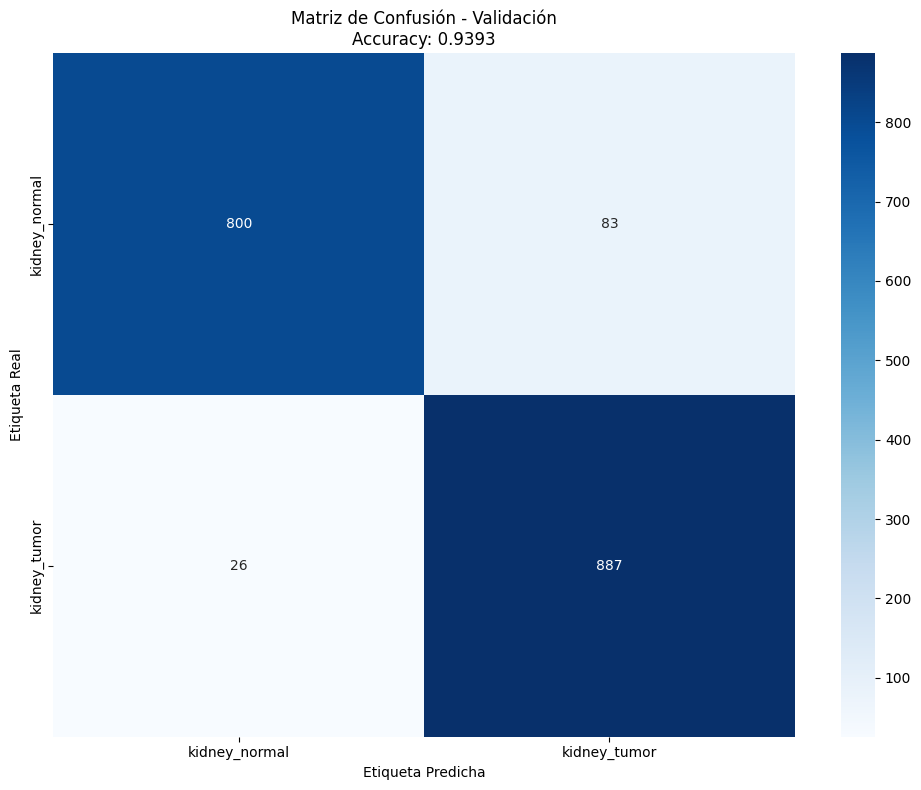

In [9]:
# Graficar matriz de confusión - Validación
plt.figure(figsize=(10, 8))
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title(f'Matriz de Confusión - Validación\nAccuracy: {val_accuracy:.4f}')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

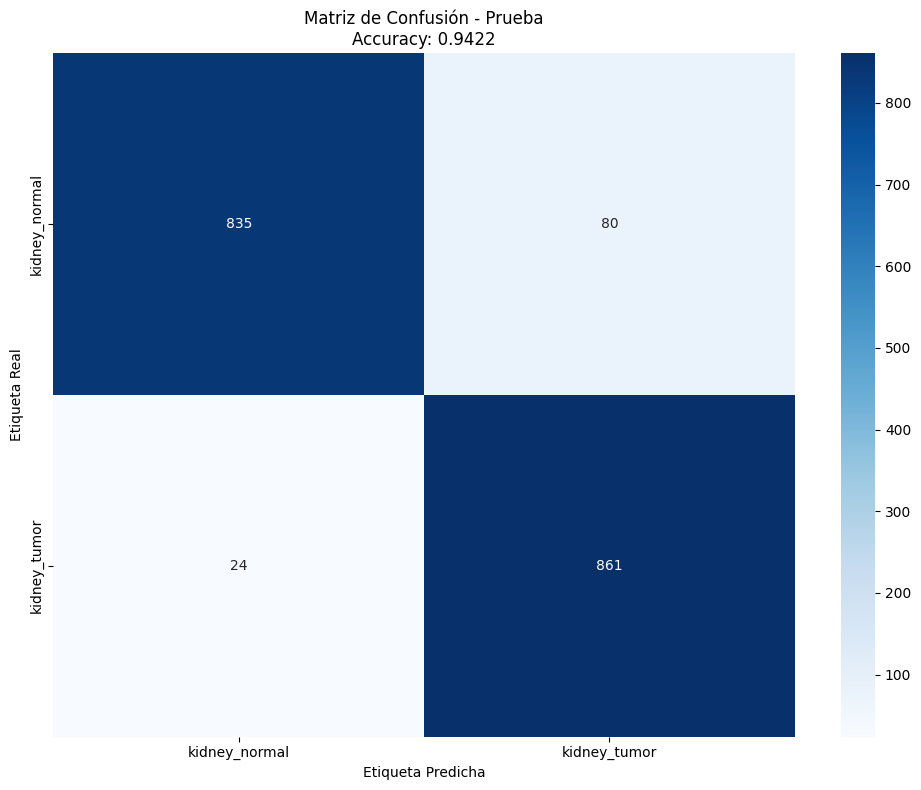

In [10]:
# Graficar matriz de confusión - Prueba
plt.figure(figsize=(10, 8))
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title(f'Matriz de Confusión - Prueba\nAccuracy: {test_accuracy:.4f}')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished


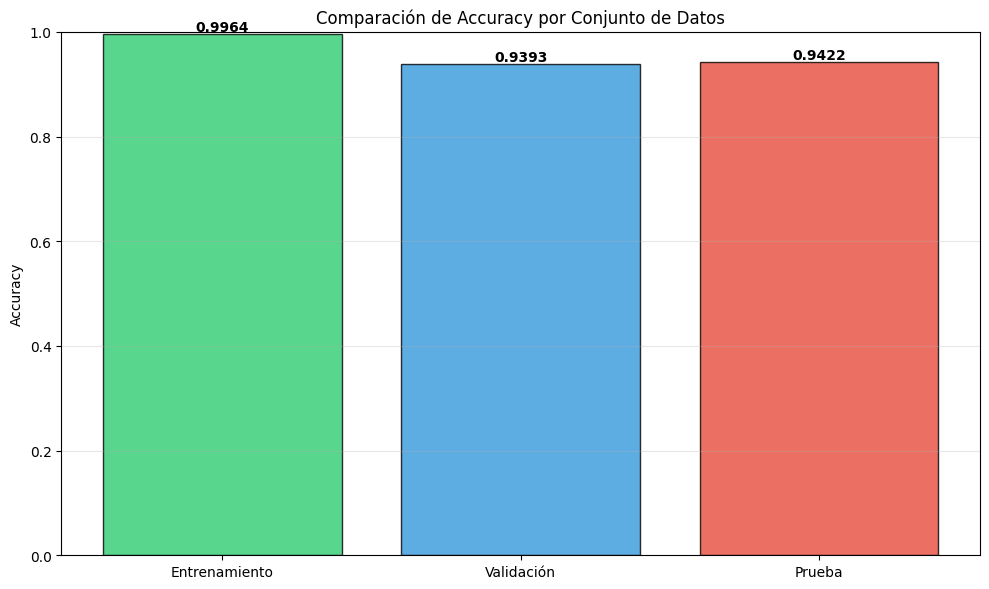


Accuracy Entrenamiento: 0.9964
Accuracy Validación: 0.9393
Accuracy Prueba: 0.9422


In [11]:
# Comparar accuracy entre conjuntos
train_accuracy = rf_model.score(X_train, y_train)

plt.figure(figsize=(10, 6))
accuracies = [train_accuracy, val_accuracy, test_accuracy]
labels = ['Entrenamiento', 'Validación', 'Prueba']
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = plt.bar(labels, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy por Conjunto de Datos')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nAccuracy Entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy Validación: {val_accuracy:.4f}")
print(f"Accuracy Prueba: {test_accuracy:.4f}")

In [ ]:
with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

: 

In [12]:
# Función para predecir una nueva imagen
def predecir_imagen(ruta_imagen, modelo, img_size, classes):
    img = Image.open(ruta_imagen).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img).flatten() / 255.0
    img_array = img_array.reshape(1, -1)
    
    prediccion = modelo.predict(img_array)[0]
    probabilidades = modelo.predict_proba(img_array)[0]
    
    print(f"Clase predicha: {classes[prediccion]}")
    print("\nProbabilidades por clase:")
    for i, prob in enumerate(probabilidades):
        print(f"  {classes[i]}: {prob:.4f}")
    
    return prediccion

# Ejemplo de uso:
# predecir_imagen('ruta/a/tu/imagen.jpg', rf_model, IMG_SIZE, CLASSES)